<a href="https://colab.research.google.com/github/Gazelle90/SmallCNN/blob/main/SmallCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#libraries used
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import models
import math
import os
from sklearn.metrics import f1_score


# The model

In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Step one:
loading data and preperation:

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


X = np.load('train_data.npy')      # shape (N, 3072) uint8
y = np.load('train_labels.npy')    # shape (N,)
X_test = np.load('test_data.npy')  # shape (N, 3072) uint8


X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

#Convertion from flat uint8 arrays → images → tensors.
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.ToPILImage(),                  # expects HWC uint8
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),  # optional but helpful
    transforms.ToTensor(),                    # -> float [0,1], CHW
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=0.25)          # optional regularization
])

transform_eval = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])


class FlatCIFARDataset(Dataset):
    def __init__(self, X_flat, y=None, transform=None):
        self.X = X_flat
        self.y = y
        self.transform = transform

    def __len__(self): return len(self.X)

    def _flat_to_hwc(self, x):  # (3072,) -> (32,32,3)
        # channels-last order like CIFAR: [R(1024), G(1024), B(1024)]
        img = x.reshape(3, 32, 32).transpose(1, 2, 0)  # CHW -> HWC
        return img.astype(np.uint8)

    def __getitem__(self, idx):
        img = self._flat_to_hwc(self.X[idx])
        img = self.transform(img) if self.transform else img
        if self.y is None:
            return img
        return img, int(self.y[idx])

trainset = FlatCIFARDataset(X_tr, y_tr, transform=transform_train)
valset   = FlatCIFARDataset(X_val, y_val, transform=transform_eval)
testset  = FlatCIFARDataset(X_test, None, transform=transform_eval)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
valloader   = DataLoader(valset,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


# Step two:
The Model:

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SmallCNN(num_classes=10).to(device)

#  Step Three:
 Loss function, Optimizer and Scheduler

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)


# Step 4:
The training loop , the early stopping technique was used in order to prevent overfitting

In [9]:
num_epochs = 75
train_losses, val_losses = [], []

#Early stopping's configuration
patience =10
min_delta = 0.0
checkpoint_path = "best_model.pth"

best_val = math.inf
epochs_no_improve = 0

for epoch in range(num_epochs):

    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)


    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(testloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


    if val_loss < (best_val - min_delta):
        best_val = val_loss
        epochs_no_improve = 0

        torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_val': best_val
        }, checkpoint_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. "
                  f"Best Val Loss: {best_val:.4f}")

            if os.path.exists(checkpoint_path):
                ckpt = torch.load(checkpoint_path, map_location=device)
                net.load_state_dict(ckpt['model_state_dict'])
                optimizer.load_state_dict(ckpt['optimizer_state_dict'])
            break

Epoch 1/75, Train Loss: 2.1080, Val Loss: 0.3967
Epoch 2/75, Train Loss: 1.9015, Val Loss: 0.3493
Epoch 3/75, Train Loss: 1.7638, Val Loss: 0.3321
Epoch 4/75, Train Loss: 1.7048, Val Loss: 0.3199
Epoch 5/75, Train Loss: 1.6531, Val Loss: 0.3076
Epoch 6/75, Train Loss: 1.6190, Val Loss: 0.3022
Epoch 7/75, Train Loss: 1.5891, Val Loss: 0.2981
Epoch 8/75, Train Loss: 1.5591, Val Loss: 0.2936
Epoch 9/75, Train Loss: 1.5347, Val Loss: 0.2834
Epoch 10/75, Train Loss: 1.5162, Val Loss: 0.2780
Epoch 11/75, Train Loss: 1.4796, Val Loss: 0.2852
Epoch 12/75, Train Loss: 1.4552, Val Loss: 0.2702
Epoch 13/75, Train Loss: 1.4446, Val Loss: 0.2615
Epoch 14/75, Train Loss: 1.4143, Val Loss: 0.2639
Epoch 15/75, Train Loss: 1.4031, Val Loss: 0.2599
Epoch 16/75, Train Loss: 1.3804, Val Loss: 0.2501
Epoch 17/75, Train Loss: 1.3592, Val Loss: 0.2466
Epoch 18/75, Train Loss: 1.3300, Val Loss: 0.2434
Epoch 19/75, Train Loss: 1.3326, Val Loss: 0.2417
Epoch 20/75, Train Loss: 1.2938, Val Loss: 0.2322
Epoch 21/

# Step 5:
Prediction and saving the results

In [10]:
from sklearn.metrics import f1_score, accuracy_score

net.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Val accuracy:", accuracy_score(y_true, y_pred))
print("Val macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Val weighted F1:", f1_score(y_true, y_pred, average='weighted'))


Val accuracy: 0.7195
Val macro F1: 0.7183699668283194
Val weighted F1: 0.7183549237809266


Visualizations and plots of the forecasts

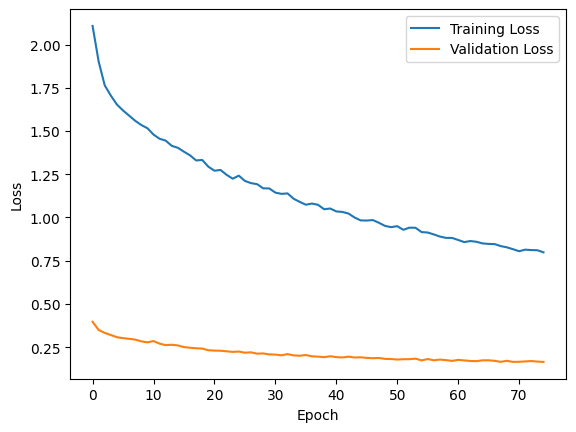

In [11]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()